In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten,
                                     Dense, Dropout, BatchNormalization)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

2025-05-01 19:19:58.589471: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-01 19:19:58.593534: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-01 19:19:58.604354: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746148798.620585  205040 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746148798.625465  205040 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746148798.638501  205040 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
# ===  Ruta del dataset ===
DATASET_DIR = Path('./malimg_dataset/malimg_paper_dataset_imgs')

# === Preprocesamiento de datos ===
filepaths = list(DATASET_DIR.glob('**/*.png'))
labels = [p.parent.name for p in filepaths]

df = pd.DataFrame({
    'filepath': filepaths,
    'label': labels
})
df['filepath'] = df['filepath'].astype(str)

# Filtrar clases con menos de 100 muestras
df = df.groupby('label').filter(lambda x: len(x) >= 100)

# Mostrar clases y conteo
print(f"Total de imágenes: {len(df)}")
print(f"Familias únicas: {df['label'].nunique()}")
print(df['label'].value_counts())


Total de imágenes: 9162
Familias únicas: 23
label
Allaple.A         2949
Allaple.L         1591
Yuner.A            800
Instantaccess      431
VB.AT              408
Fakerean           381
Lolyda.AA1         213
C2LOP.gen!g        200
Alueron.gen!J      198
Lolyda.AA2         184
Dialplatform.B     177
Dontovo.A          162
Lolyda.AT          159
Rbot!gen           158
C2LOP.P            146
Obfuscator.AD      142
Malex.gen!J        136
Swizzor.gen!I      132
Swizzor.gen!E      128
Lolyda.AA3         123
Adialer.C          122
Agent.FYI          116
Autorun.K          106
Name: count, dtype: int64


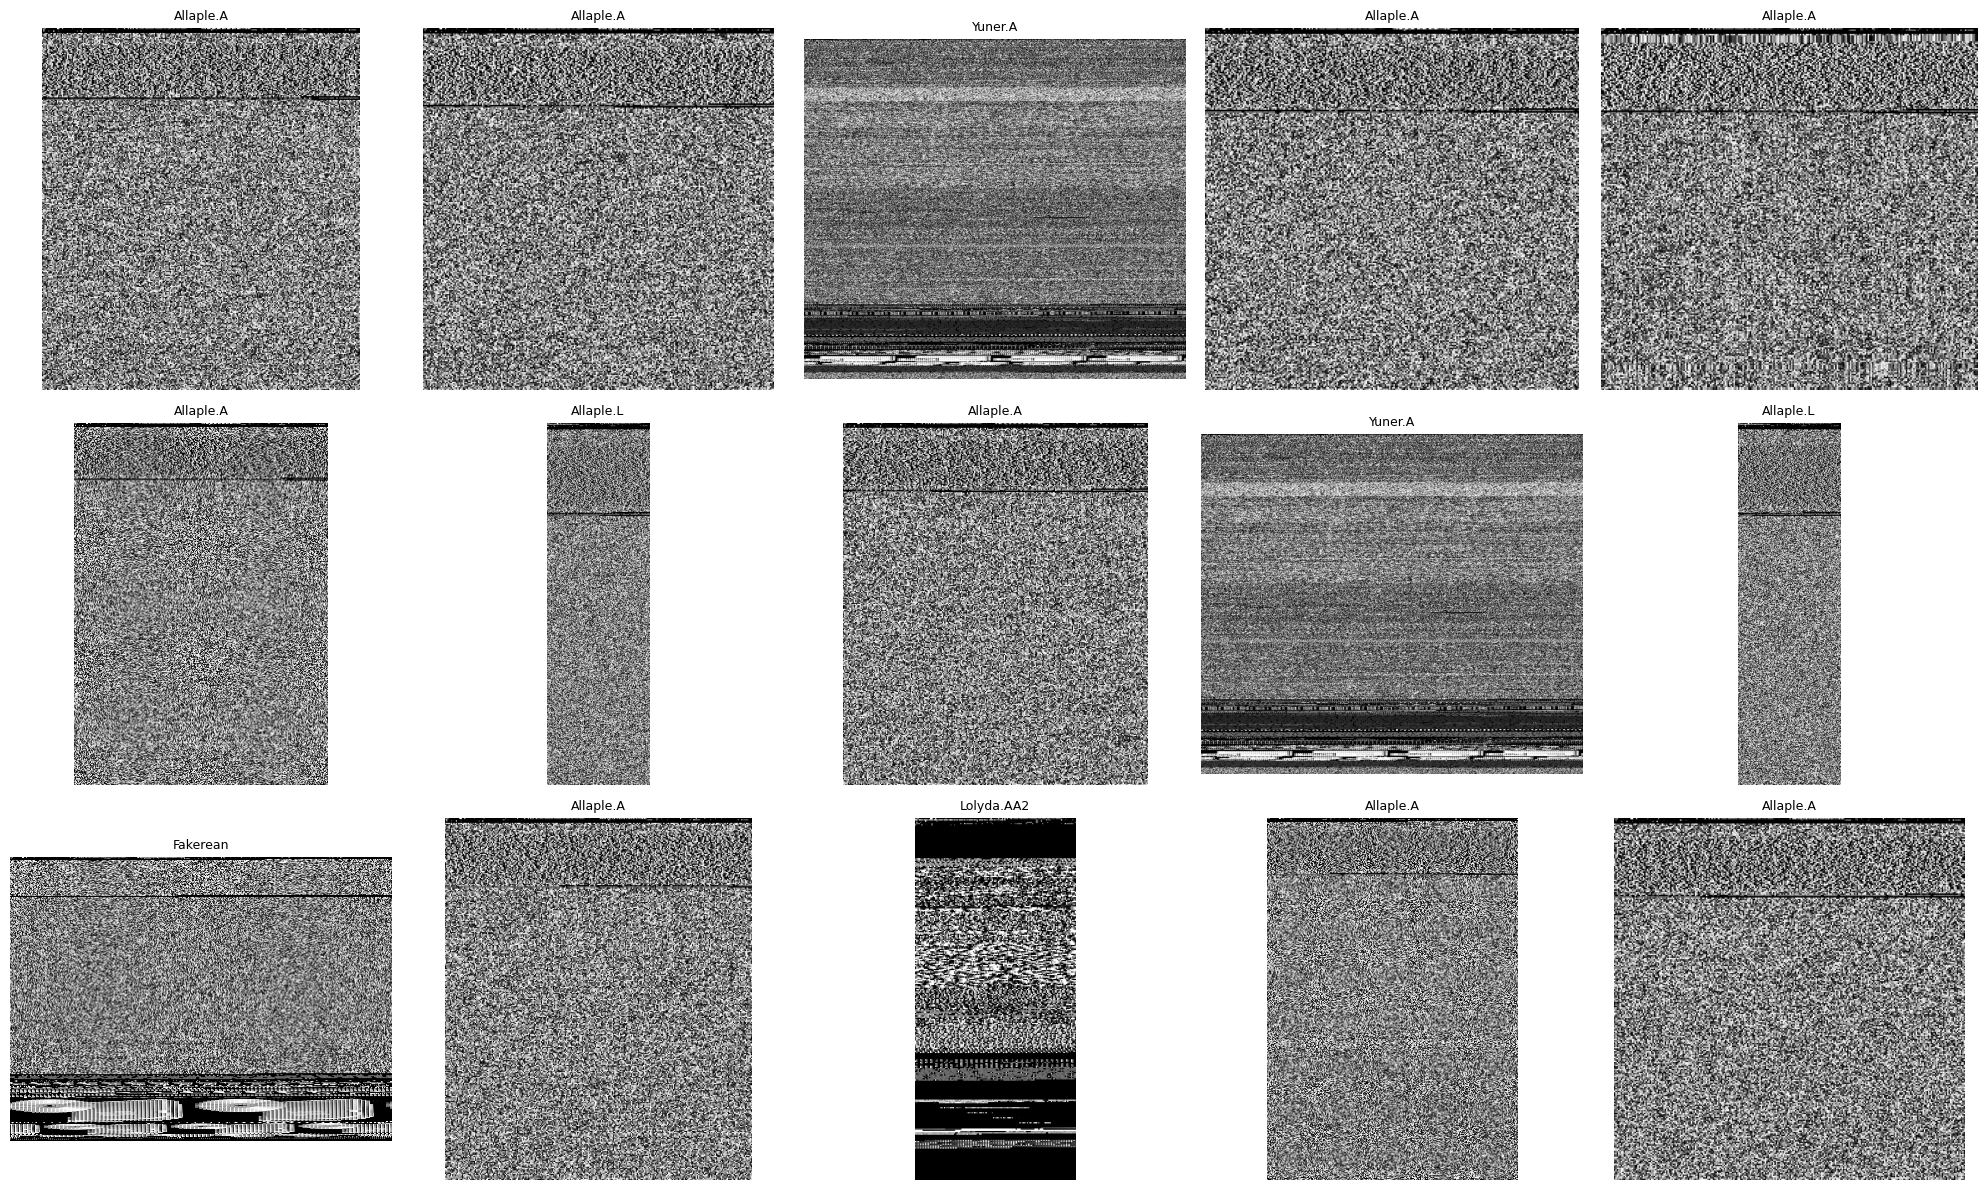

In [3]:
# === Visualizar algunas imágenes de ejemplo ===
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
for ax, (idx, row) in zip(axes.flatten(), df.sample(15).iterrows()):
    img = plt.imread(row['filepath'])
    ax.imshow(img, cmap='gray')
    ax.set_title(row['label'], fontsize=9)
    ax.axis('off')
plt.tight_layout()
plt.show()


In [4]:
# === Preparación de datos ===
IMG_SIZE = (128, 128)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_dataframe(
    df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

valid_generator = train_datagen.flow_from_dataframe(
    df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 6414 validated image filenames belonging to 23 classes.
Found 2748 validated image filenames belonging to 23 classes.


In [5]:
# === Construcción del modelo CNN ===
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])

model.summary()

/home/arg/Documents/uvg/Security_DS/env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1746148802.014775  205040 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1746148802.015761  205040 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 23)             │         2,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,308,503 (12.62 MB)

 Trainable params: 3,308,055 (12.62 MB)

 Non-trainable params: 448 (1.75 KB)

In [6]:
# === Compilación ===
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [7]:
# === Entrenamiento con EarlyStopping ===
early = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=50,
    callbacks=[early]
)


/home/arg/Documents/uvg/Security_DS/env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 131s 643ms/step - accuracy: 0.5977 - loss: 2.6124 - val_accuracy: 0.0000e+00 - val_loss: 45.0657
Epoch 2/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 125s 622ms/step - accuracy: 0.7597 - loss: 0.8906 - val_accuracy: 0.0084 - val_loss: 33.9334
Epoch 3/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 125s 619ms/step - accuracy: 0.8222 - loss: 0.6190 - val_accuracy: 0.0000e+00 - val_loss: 31.1878
Epoch 4/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 124s 615ms/step - accuracy: 0.8323 - loss: 0.5270 - val_accuracy: 0.0000e+00 - val_loss: 35.9706
Epoch 5/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 123s 613ms/step - accuracy: 0.8422 - loss: 0.5152 - val_accuracy: 0.0000e+00 - val_loss: 37.1385
Epoch 6/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 121s 601ms/step - accuracy: 0.8544 - loss: 0.4907 - val_accuracy: 0.0000e+00 - val_loss: 58.2275
Epoch 7/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 121s 601ms/step - accuracy: 0.8540 - loss: 0.4930 - val_accuracy: 0.0000e+00 - val_loss: 17.9085
Epoch 8/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 118s 

In [8]:
# === Evaluación ===
val_loss, val_accuracy = model.evaluate(valid_generator)
print(f"Loss en validación: {val_loss:.4f}")
print(f"Accuracy en validación: {val_accuracy:.4f}")


86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 161ms/step - accuracy: 0.0000e+00 - loss: 27.3991
Loss en validación: 17.7828
Accuracy en validación: 0.0000


86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 173ms/step
                precision    recall  f1-score   support

     Adialer.C       0.00      0.00      0.00       0.0
     Allaple.A       0.00      0.00      0.00       0.0
     Allaple.L       0.00      0.00      0.00    1587.0
 Alueron.gen!J       0.00      0.00      0.00       0.0
     Autorun.K       0.00      0.00      0.00     106.0
       C2LOP.P       0.00      0.00      0.00       0.0
   C2LOP.gen!g       0.00      0.00      0.00     200.0
Dialplatform.B       0.00      0.00      0.00       0.0
     Dontovo.A       0.00      0.00      0.00       0.0
      Fakerean       0.00      0.00      0.00       0.0
 Instantaccess       0.00      0.00      0.00     431.0
    Lolyda.AA1       0.00      0.00      0.00       0.0
    Lolyda.AA2       0.00      0.00      0.00       0.0
    Lolyda.AA3       0.00      0.00      0.00     123.0
     Lolyda.AT       0.00      0.00      0.00     159.0
   Malex.gen!J       0.00      0.00      0.00       0.0
 Obfu

/home/arg/Documents/uvg/Security_DS/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arg/Documents/uvg/Security_DS/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arg/Documents/uvg/Security_DS/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

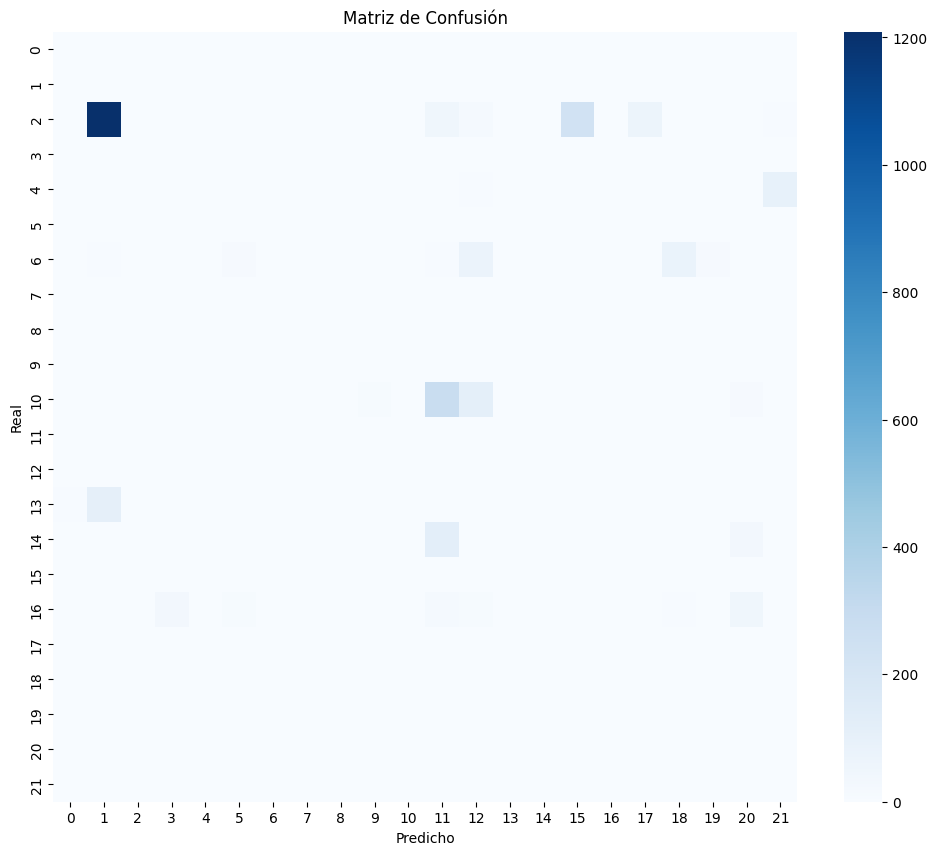

In [9]:
# ===  Métricas ===
y_pred = model.predict(valid_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = valid_generator.classes

labels_presentes = unique_labels(y_true, y_pred_classes)
nombres_presentes = [k for k, v in valid_generator.class_indices.items() if v in labels_presentes]

print(classification_report(y_true, y_pred_classes, target_names=nombres_presentes))

conf_mat = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12,10))
sns.heatmap(conf_mat, annot=False, cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

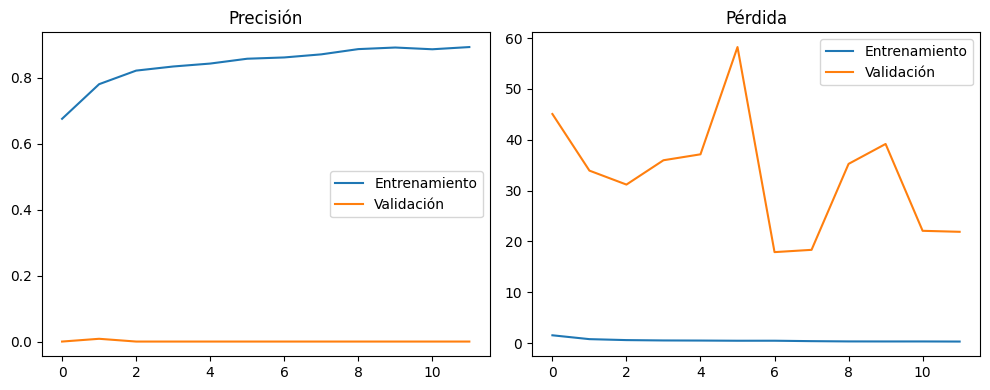

In [10]:
# === Gráficas de entrenamiento ===
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida')
plt.legend()
plt.tight_layout()
plt.show()


# Comentario sobre las clases utilizadas
Se utilizaron las 23 clases del conjunto de datos que contaban con al menos 100 muestras.
Esta decisión se tomó para asegurar que cada clase tuviera representación suficiente durante el entrenamiento y validación,
evitando así el sesgo hacia clases dominantes y permitiendo que el modelo tenga una base más balanceada desde el punto de vista cuantitativo.
Aunque el desbalance persiste parcialmente, este filtro mejora la calidad del aprendizaje.
Clases con menos de 100 muestras fueron omitidas para evitar que el modelo las ignore o introduzca ruido en las métricas.
Se priorizó mantener clases con diversidad semántica y suficiente soporte estadístico para evaluar la capacidad discriminativa del modelo.
